In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 

from sklearn import tree
from matplotlib import pyplot as plt 
import random
from sklearn import preprocessing

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
pd.set_option('mode.chained_assignment', None)


In [3]:
pd.set_option('display.max_columns', 500)


In [39]:
def run_single_geography_model(data_df, predict_df, df_cols, predict_cols, name):
    """
    Note that predict_cols[0] must be equal to the binary gentrification varible
    """
    # drop na
    d = {}
    for i in predict_cols:
        d[i] = predict_df[i]
    # merge into new df
    df = data_df.join(pd.DataFrame(
        #index="geo_fips",
        data=d
    ))
    s = df.shape
    df = df.dropna()
    print("previous to dropping", s, "after dropping", df.shape)
    new_predict = pd.DataFrame()
    for i in predict_cols:
        new_predict[i] = df[i]
    del data_df
    # new data_df
    data_df = pd.DataFrame()
    for i in df_cols + ["geo_fips"]:
        data_df[i] = df[i]
    print(new_predict.shape, data_df.shape)
    assert new_predict.shape[0] == data_df.shape[0], "after removing nulls, predict and data don't have the same # of rows"
    # normal
    for i in predict_cols:
        print("=============================================================")
        if "disp" in i.lower():
            print(i, "regression")
            model, stats = train_model(data_df[df_cols], new_predict, df_cols, i, "regression")
            diff = stats.loc[(stats['diff'] >= stats["diff"].quantile(0.01)) & (stats['diff'] <= stats["diff"].quantile(0.99))]["diff"]
            print("description")
            print(stats['diff'].describe())
            #plt.hist(stats["diff"])
            plt.hist(diff)
            plt.show()
        else:
            print(i, "classification")
            model, stats, confusion_matrix = train_model(data_df[df_cols], new_predict, df_cols, i, "classification")
            print("accuracy score", stats)
            print("confusion matrix")
            print(confusion_matrix)
            output_csv(model, data_df, df_cols, new_predict[i], "Normal set", name)
    # equal number of gentrified and non-gent geometries 
    original_data = data_df.copy()
    original_predict = new_predict.copy()
    temp_table = data_df.copy()
    temp_table[predict_cols[0]] = new_predict[predict_cols[0]]
    temp_table = temp_table.loc[temp_table[predict_cols[0]] == 1]
    gent_indicies = temp_table.index
    other_indicies = set(data_df.index) - set(gent_indicies)
    non_gent_selected_indicies = random.sample(list(other_indicies), len(gent_indicies))
    assert len(non_gent_selected_indicies) == len(gent_indicies), "gent data is not split 50/50"
    print(list(non_gent_selected_indicies)[:5], type(non_gent_selected_indicies), type(gent_indicies))
    gent_indicies = list(gent_indicies)
    data_df = data_df.loc[non_gent_selected_indicies + gent_indicies]
    new_predict = new_predict.loc[non_gent_selected_indicies + gent_indicies]
    #validation = 
    print("=============================================================")
    print("=============================================================")
    print("=============================================================")
    print("=====================50/50 split=============================")
    for i in predict_cols:
        print("=============================================================")
        if "disp" in i.lower():
            print(i, "regression", "50/50 split")
            model, stats = train_model(data_df[df_cols], new_predict, df_cols, i, "regression")
            diff = stats.loc[(stats['diff'] >= stats["diff"].quantile(0.01)) & (stats['diff'] <= stats["diff"].quantile(0.99))]["diff"]
            print("description")
            print(stats['diff'].describe())
            #plt.hist(stats["diff"])
            plt.hist(diff)
            plt.show()
        else:
            print(i, "classification" , "50/50 split")
            model, stats, confusion_matrix = train_model(data_df[df_cols], new_predict, df_cols, i, "classification")
            print("accuracy score", stats)
            print("confusion matrix")
            print(confusion_matrix)
            output_csv(model, original_data, df_cols, original_predict[i], "Even split" ,name)

        

In [5]:
def optimize_classification(x1_train, y1_train):
    def helper(depth):
        #clf = tree.DecisionTreeClassifier(max_depth=50, criterion="entropy")
        clf = tree.DecisionTreeClassifier(max_depth=depth, criterion="entropy")
        clf = clf.fit(x1_train, y1_train)
        z = clf.predict(x1_train)
        stats = accuracy_score(z, y1_train)
        matrix = confusion_matrix(y1_train, z) 
        return clf, stats, matrix
    max_depth = None
    clf = None
    max_accuracy = 0
    max_determinant = 0
    for i in range(10,50,5):
        model, acc, matrix = helper(i)
        #if acc > max_accuracy:
        det = np.linalg.det(matrix)
        if det > max_determinant:
            clf = model
            max_accuracy = acc
            max_depth = i
            max_determinant = det
    return clf, max_depth
    

In [6]:
def optimize_regression(x1_train, y1_train):
    def helper(depth):
        clf = tree.DecisionTreeRegressor(max_depth=depth, criterion="entropy")
        clf = clf.fit(x1_train, y1_train)
        z = clf.predict(x1_train)
        stats = accuracy_score(z, y1_train)
        matrix = confusion_matrix(y1_train, z) 
        return clf, stats, matrix
    max_depth = None
    clf = None
    max_accuracy = 0
    max_determinant = 0
    for i in range(10,50,5):
        model, acc, matrix = helper(i)
        #if acc > max_accuracy:
        det = np.linalg.det(matrix)
        if det > max_determinant:
            clf = model
            max_accuracy = acc
            max_depth = i
            max_determinant = det
    return clf, max_depth
    

In [46]:
def train_model(df, predict_df, df_cols, predict_col, model_type):
    min_max_scaler = preprocessing.MinMaxScaler()
    df_norm = pd.DataFrame(min_max_scaler.fit_transform(df), columns=df_cols)
    X = df_norm
    Y = predict_df[predict_col]
    #x1_train, x1_val, y1_train, y1_val = train_test_split(X, Y, test_size=0.30)
    x1_train, x1_val, y1_train, y1_val = train_test_split(X, Y, test_size=0.33, random_state=42)
    print("size of training set", str(y1_train.shape), "size of testing set", len(y1_val), "original", str(Y.shape))
    # clean Data
    x1_train, y1_train = clean_data(x1_train, y1_train)
    
    if model_type == "regression":
        clf = tree.DecisionTreeRegressor() # max_depth=50
        #clf = clf.fit(x1_train._get_numeric_data(), y1_train)
        clf = clf.fit(x1_train, y1_train)
        #clf, max_depth = optimize_regression(x1_train, y1_train)
        z = clf.predict(x1_val)
        stats = pd.DataFrame({"predicted": z, "actual": y1_val, "diff": (y1_val - z)})
        return clf, stats
    else:
        #clf = tree.DecisionTreeClassifier(max_depth=50, criterion="entropy")
        #clf = clf.fit(x1_train, y1_train)
        clf, max_depth = optimize_classification(x1_train, y1_train)
        z = clf.predict(x1_val)
        #tree.plot_tree(clf)
        from sklearn.externals.six import StringIO  
        from IPython.display import Image  
        from sklearn.tree import export_graphviz
        import pydotplus
        dot_data = StringIO()
        export_graphviz(clf, out_file=dot_data,  
                        filled=True, rounded=True,
                        special_characters=True)
        graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
        display(Image(graph.create_png()))
        
        stats = accuracy_score(z, y1_val)
        confusion = confusion_matrix(y1_val, z) 
        return clf, stats, confusion

In [8]:
def confusion(a, b):
    """
    a must be from data, b must be from model
    """
    assert a in [0, 1] and b in [0, 1], "not binary 0/1"
    if a and b:
        #print("TP")
        return 0
    elif a and not b:
        #print("FN")
        return 1
    elif not a and b:
        #print("FP")
        return 2
    elif not a and not b:
        #print("TN")
        return 3

In [9]:
def output_csv(clf, data, df_cols, predict, split_type, name):
    z = clf.predict(data[df_cols])
    #stats = accuracy_score(z, predict)
    #print(data.columns)
    #fips = data["geo_fips"]
    #print(data["geo_fips"])
    df = pd.DataFrame({"actual": predict, "predicted": z, "geo_fips": data["geo_fips"]})
    arr = []
    for index, row in df.iterrows():
        #print(row.get("geo_fips"))
        #print(df.loc[index,'Qty'] == 1)
        """
        val = None;
        TP = df.loc[index,'actual'] == 1 and df.loc[index,'predicted'] == 1 #np.sum(np.logical_and(pred_labels == 1, true_labels == 1))
        TN = df.loc[index,'actual'] == 0 and df.loc[index,'predicted'] == 0
        #np.sum(np.logical_and(pred_labels == 0, true_labels == 0))
        FP = df.loc[index,'actual'] == 1 and df.loc[index,'predicted'] == 0
        #np.sum(np.logical_and(pred_labels == 1, true_labels == 0))
        FN = df.loc[index,'actual'] == 0 and df.loc[index,'predicted'] == 1
        #np.sum(np.logical_and(pred_labels == 0, true_labels == 1))
        if TP:
            val = 0
        elif TN:
            val = 3
        elif FP:
            val = 2
        elif FN:
            val = 1
        arr.append(val)
        """
        arr.append(confusion(df.loc[index,'actual'], df.loc[index,'predicted']))
    df["false_positive"] = arr
    
    df.to_csv("output/" + name + " " + split_type + ".csv")

In [10]:
def clean_data(x_train, y_train):
    #print(type(x_train), type(y_train))
    x_train["y_train"] = y_train
    first = x_train["y_train"].quantile(0.1)
    second = x_train["y_train"].quantile(0.9)
    df = x_train.loc[(x_train['y_train'] >= first) & (x_train['y_train'] <= second)]
    #print(df.columns)
    y_train = df["y_train"]
    df = df.drop(columns=["y_train"])
    return df, y_train

In [11]:
def stack_data(df1, cols1, df2, cols2, predict, predict_cols1, predict_cols2):
    assert len(cols1) == len(cols2), "input sizes are not the same"
    df1 = df1[cols1]
    df2 = df2[cols2]
    stacked_data = np.vstack((df1.values, df2.values))
    predict1 = predict[predict_cols1]
    predict2 = predict[predict_cols2]
    stacked_predict = np.vstack((predict1.values, predict2.values))
    stacked_data = pd.DataFrame(stacked_data, columns=cols1)
    stacked_predict = pd.DataFrame(stacked_predict, columns=predict_cols1)
    return stacked_data, stacked_predict

In [12]:
def stack_data_diff_geographies(df1, cols1, df2, cols2, predict1, predict2, predict_cols1, predict_cols2):
    assert len(cols1) == len(cols2), "input sizes are not the same"
    df1 = df1[cols1]
    df2 = df2[cols2]
    stacked_data = np.vstack((df1.values, df2.values))
    predict1 = predict1[predict_cols1]
    predict2 = predict2[predict_cols2]
    stacked_predict = np.vstack((predict1.values, predict2.values))
    stacked_data = pd.DataFrame(stacked_data, columns=cols1)
    stacked_predict = pd.DataFrame(stacked_predict, columns=predict_cols1)
    return stacked_data, stacked_predict

# Collumn Data for all the locations and years

In [13]:
ny_00_cols = ["TOD", "downtown", "per_asian_00", "mhval00", "empd02", "hh00", "hinc00", "hu_00", "per_black_00", "per_built_90_00", "per_car_commute_00", "per_col00", "per_hhwchild_00", "per_latino_00", "per_nonwhite00", "per_owners_00", "per_rent00", "per_units_pre50", "pop00"]
ny_90_cols = ["TOD", "downtown", "per_asian_90", "mhval90", "empd02", "hh_90", "hinc90", "hu_90", "per_black_90", "per_built_80_90", "per_car_commute_90", "per_col90", "per_hhwchild_90", "per_latino_90", "per_nonwhite90", "per_owners_90", "per_rent90", "per_units_pre50", "pop90"]

sf_00_cols = ["tod", "downtown", "per_asian00", "mhval00", "emp_density00", "hh00", "hinc00", "hu00", "per_nhblk00", "per_built90_00", "per_carcommute00", "per_col00", "per_hhwchild00", "per_hisp00", "per_nonwhite00", "per_own00", "per_rent00", "per_units_pre50_00", "pop00"]
sf_90_cols = ["tod", "downtown", "per_asian90", "mhval90", "emp_density90", "hh90", "hinc90", "hu90", "per_nhblk90", "per_built80_90", "per_carcommute90", "per_col90", "per_hhwchild90", "per_hisp90", "per_nonwhite90", "per_own90", "per_rent90", "per_units_pre50_90", "pop90"]

In [14]:
ny_00_df = pd.read_excel("UDP_NY_2016_7.13.19_selectedNYNJcounties.xlsx", sheet_name="2000 data")
ny_90_df = pd.read_excel("UDP_NY_2016_7.13.19_selectedNYNJcounties.xlsx", sheet_name="1990 data")

sf_00_df = pd.read_excel("UDP_SF_2015_6.6.19.xlsx", sheet_name="2000 data")
sf_90_df = pd.read_excel("UDP_SF_2015_6.6.19.xlsx", sheet_name="1990 data")


to_predict_ny = pd.read_excel("UDP_NY_2016_7.13.19_selectedNYNJcounties.xlsx", sheet_name="to predict")
# put these 2 collumn value lists in the same order
predict_ny_90_cols = ["gent90_00", "Disp_index_90_00_count", "Disp_index_90_00_pctch_count", "Disp_index_90_00_pctch_per"]
predict_ny_00_cols = ["gent00_16", "Disp_index_00_16_count", "Disp_index_00_15_pctch_count", "Disp_index_00_15_pctch_per"]
predict_sf_90_cols = ["gent90_00_v2", "Disp_index_90_00_count", "Disp_index_90_00_pctch_count", "Disp_index_90_00_pctch_per"]
predict_sf_00_cols = ["gent00_15_v2", "Disp_index_00_15_count", "Disp_index_00_15_pctch_count", "Disp_index_00_15_pctch_per"]

to_predict_sf = pd.read_excel("UDP_SF_2015_6.6.19.xlsx", sheet_name="to predict")
#predict_ny_00_cols = ["gent00_15_v2", "Disp_index_90_00_count", "Disp_index_90_00_pctch_count", "Disp_index_90_00_pctch_per", "Disp_index_00_15_count", "Disp_index_00_15_pctch_count", "Disp_index_00_15_pctch_per", "Gent_index_90_00", "Gent_index_00_15"]


# 1990s NY

previous to dropping (3852, 26) after dropping (3066, 26)
(3066, 4) (3066, 20)
gent90_00 classification
size of training set (2054,) size of testing set 1012 original (3066,)


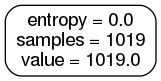

accuracy score 0.9179841897233202
confusion matrix
[[929   0]
 [ 83   0]]
Disp_index_90_00_count regression
size of training set (2054,) size of testing set 1012 original (3066,)
description
count    1012.000000
mean       14.597993
std       165.192820
min     -2182.731600
25%       -64.170490
50%        15.333410
75%        98.185181
max       650.067807
Name: diff, dtype: float64


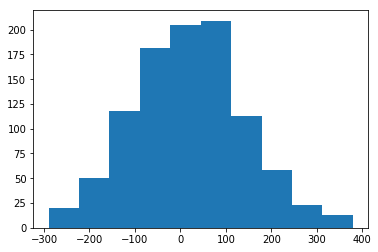

Disp_index_90_00_pctch_count regression
size of training set (2054,) size of testing set 1012 original (3066,)
description
count     1012.000000
mean        16.123168
std        510.101712
min         -0.962476
25%         -0.147240
50%          0.025390
75%          0.230063
max      16227.409287
Name: diff, dtype: float64


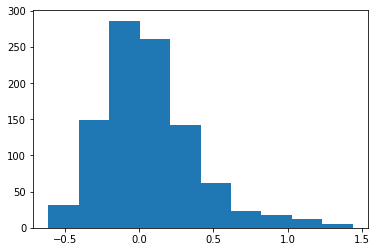

Disp_index_90_00_pctch_per regression
size of training set (2054,) size of testing set 1012 original (3066,)
description
count    1012.000000
mean        0.000732
std         0.103622
min        -0.924276
25%        -0.049641
50%         0.006397
75%         0.063163
max         0.339441
Name: diff, dtype: float64


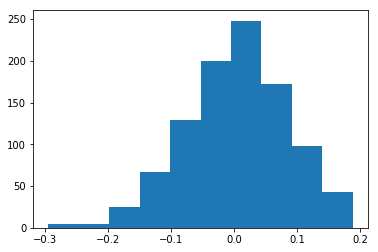

[2229, 896, 2991, 1852, 1724] <class 'list'> <class 'pandas.core.indexes.numeric.Int64Index'>
=====================50/50 split=============================
gent90_00 classification 50/50 split
size of training set (349,) size of testing set 173 original (522,)


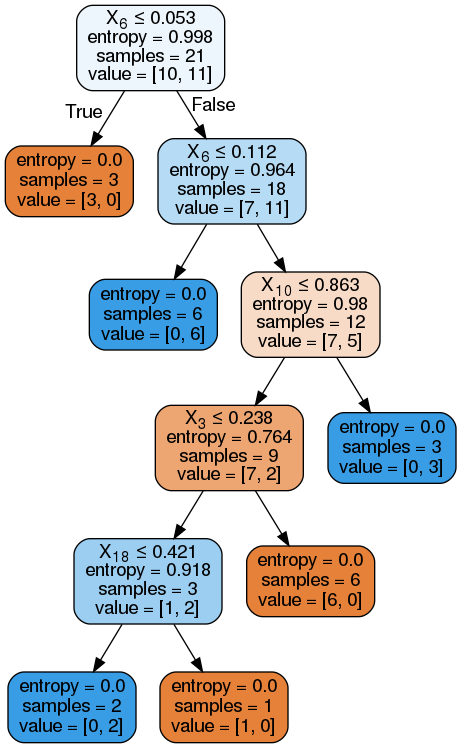

accuracy score 0.6011560693641619
confusion matrix
[[60 30]
 [39 44]]
Disp_index_90_00_count regression 50/50 split
size of training set (349,) size of testing set 173 original (522,)
description
count     173.000000
mean       29.011068
std       214.470174
min     -1539.664257
25%       -67.244415
50%        13.204986
75%       106.145996
max      1491.603219
Name: diff, dtype: float64


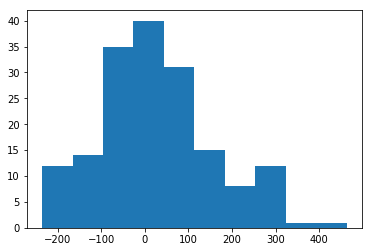

Disp_index_90_00_pctch_count regression 50/50 split
size of training set (349,) size of testing set 173 original (522,)
description
count    173.000000
mean       0.082160
std        0.363037
min       -0.731908
25%       -0.132686
50%       -0.008789
75%        0.207842
max        2.192862
Name: diff, dtype: float64


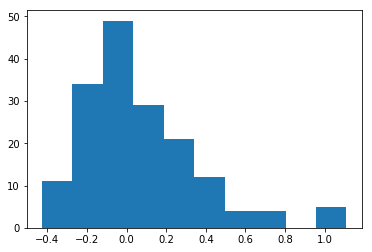

Disp_index_90_00_pctch_per regression 50/50 split
size of training set (349,) size of testing set 173 original (522,)
description
count    173.000000
mean      -0.013361
std        0.115530
min       -0.933334
25%       -0.061007
50%       -0.021707
75%        0.045196
max        0.304977
Name: diff, dtype: float64


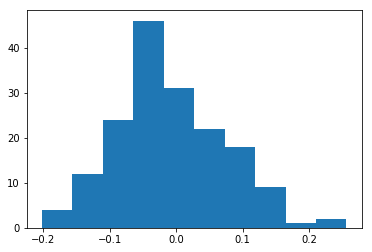

In [47]:
run_single_geography_model(ny_90_df, to_predict_ny, ny_90_cols, predict_ny_90_cols, "1990s NY")

# 2000s NY

previous to dropping (3852, 28) after dropping (3067, 28)
(3067, 4) (3067, 20)
gent00_16 classification
size of training set (2054,) size of testing set 1013 original (3067,)


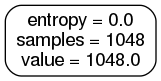

accuracy score 0.9249753208292202
confusion matrix
[[937   0]
 [ 76   0]]
Disp_index_00_16_count regression
size of training set (2054,) size of testing set 1013 original (3067,)
description
count    1013.000000
mean        3.950671
std       172.877494
min      -755.154513
25%      -100.646031
50%        -0.950440
75%        99.990997
max      1078.610971
Name: diff, dtype: float64


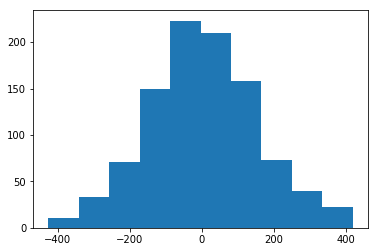

Disp_index_00_15_pctch_count regression
size of training set (2054,) size of testing set 1013 original (3067,)
description
count    1013.000000
mean        0.044893
std         0.432985
min        -0.804072
25%        -0.183384
50%         0.012919
75%         0.202752
max         6.556295
Name: diff, dtype: float64


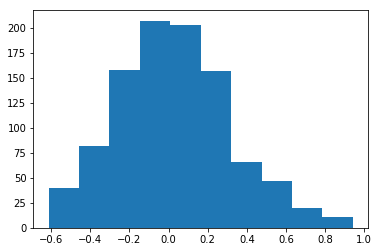

Disp_index_00_15_pctch_per regression
size of training set (2054,) size of testing set 1013 original (3067,)
description
count    1013.000000
mean        0.001501
std         0.095424
min        -0.305138
25%        -0.060946
50%         0.004904
75%         0.069149
max         0.274194
Name: diff, dtype: float64


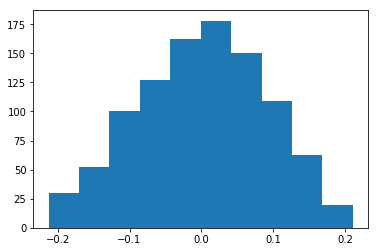

[1642, 986, 2437, 0, 3301] <class 'list'> <class 'pandas.core.indexes.numeric.Int64Index'>
=====================50/50 split=============================
gent00_16 classification 50/50 split
size of training set (329,) size of testing set 163 original (492,)


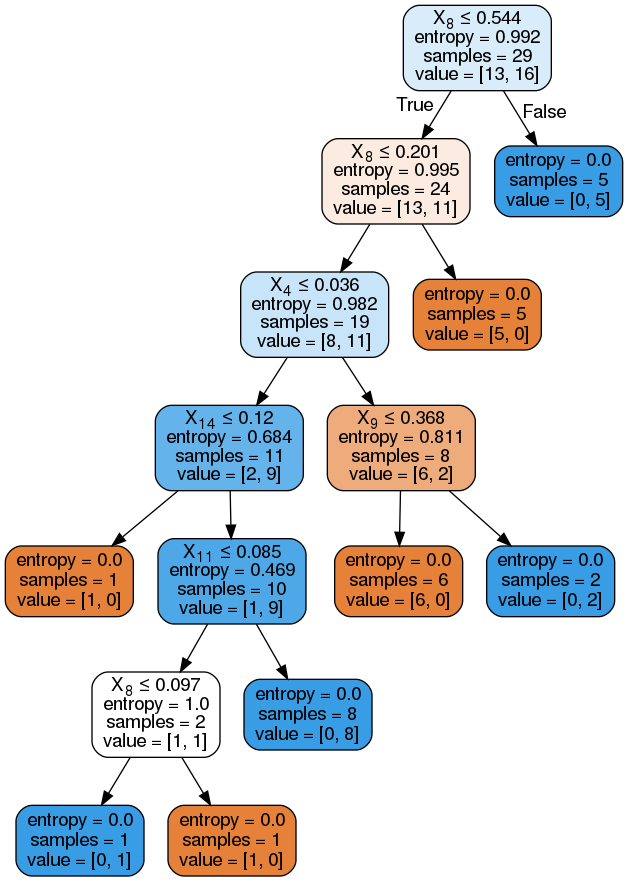

accuracy score 0.4294478527607362
confusion matrix
[[32 52]
 [41 38]]
Disp_index_00_16_count regression 50/50 split
size of training set (329,) size of testing set 163 original (492,)
description
count    163.000000
mean      32.068290
std      127.779612
min     -346.376614
25%      -63.219138
50%       18.811905
75%      106.781864
max      406.223455
Name: diff, dtype: float64


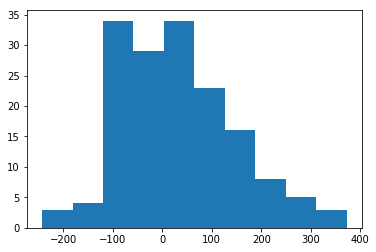

Disp_index_00_15_pctch_count regression 50/50 split
size of training set (329,) size of testing set 163 original (492,)
description
count    163.000000
mean       0.032338
std        0.329757
min       -0.842345
25%       -0.167148
50%       -0.026355
75%        0.202971
max        1.108798
Name: diff, dtype: float64


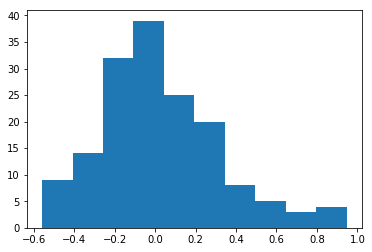

Disp_index_00_15_pctch_per regression 50/50 split
size of training set (329,) size of testing set 163 original (492,)
description
count    163.000000
mean       0.016484
std        0.081504
min       -0.254212
25%       -0.034929
50%        0.008295
75%        0.063055
max        0.292892
Name: diff, dtype: float64


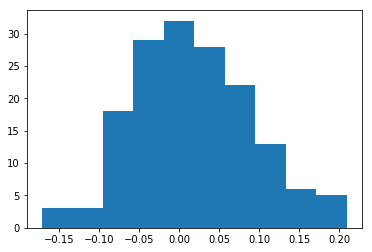

In [48]:
run_single_geography_model(ny_00_df, to_predict_ny, ny_00_cols, predict_ny_00_cols, "2000s Ny")

# Stacking decades of NY Data

In [55]:
df_data, df_predict = stack_data(ny_00_df, ny_00_cols + ["geo_fips"], ny_90_df, ny_90_cols + ["geo_fips"], to_predict_ny, predict_ny_00_cols, predict_ny_90_cols)

print(type(df_data), type(df_predict), df_data.columns)


<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> Index(['TOD', 'downtown', 'per_asian_00', 'mhval00', 'empd02', 'hh00',
       'hinc00', 'hu_00', 'per_black_00', 'per_built_90_00',
       'per_car_commute_00', 'per_col00', 'per_hhwchild_00', 'per_latino_00',
       'per_nonwhite00', 'per_owners_00', 'per_rent00', 'per_units_pre50',
       'pop00', 'geo_fips'],
      dtype='object')


previous to dropping (7704, 24) after dropping (6133, 24)
(6133, 4) (6133, 20)
gent00_16 classification
size of training set (4109,) size of testing set 2024 original (6133,)


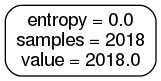

accuracy score 0.9239130434782609
confusion matrix
[[1870    0]
 [ 154    0]]
Disp_index_00_16_count regression
size of training set (4109,) size of testing set 2024 original (6133,)
description
count    2024.000000
mean        0.555591
std       176.220564
min     -2242.073149
25%       -96.702188
50%         0.534882
75%        89.397648
max      1667.492692
Name: diff, dtype: float64


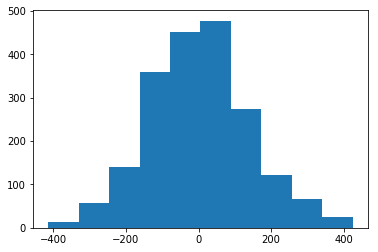

Disp_index_00_15_pctch_count regression
size of training set (4109,) size of testing set 2024 original (6133,)
description
count    2024.000000
mean        0.023355
std         0.410623
min        -1.179422
25%        -0.204244
50%        -0.006454
75%         0.184027
max         7.181922
Name: diff, dtype: float64


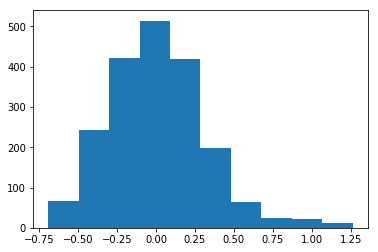

Disp_index_00_15_pctch_per regression
size of training set (4109,) size of testing set 2024 original (6133,)
description
count    2024.000000
mean       -0.005594
std         0.107763
min        -2.063997
25%        -0.062667
50%        -0.000639
75%         0.056220
max         0.260417
Name: diff, dtype: float64


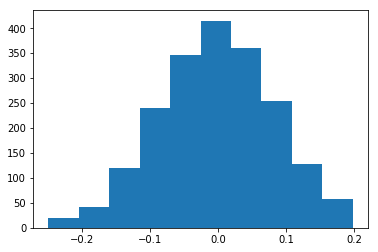

[3548, 6931, 3489, 5345, 6722] <class 'list'> <class 'pandas.core.indexes.numeric.Int64Index'>
=====================50/50 split=============================
gent00_16 classification 50/50 split
size of training set (679,) size of testing set 335 original (1014,)


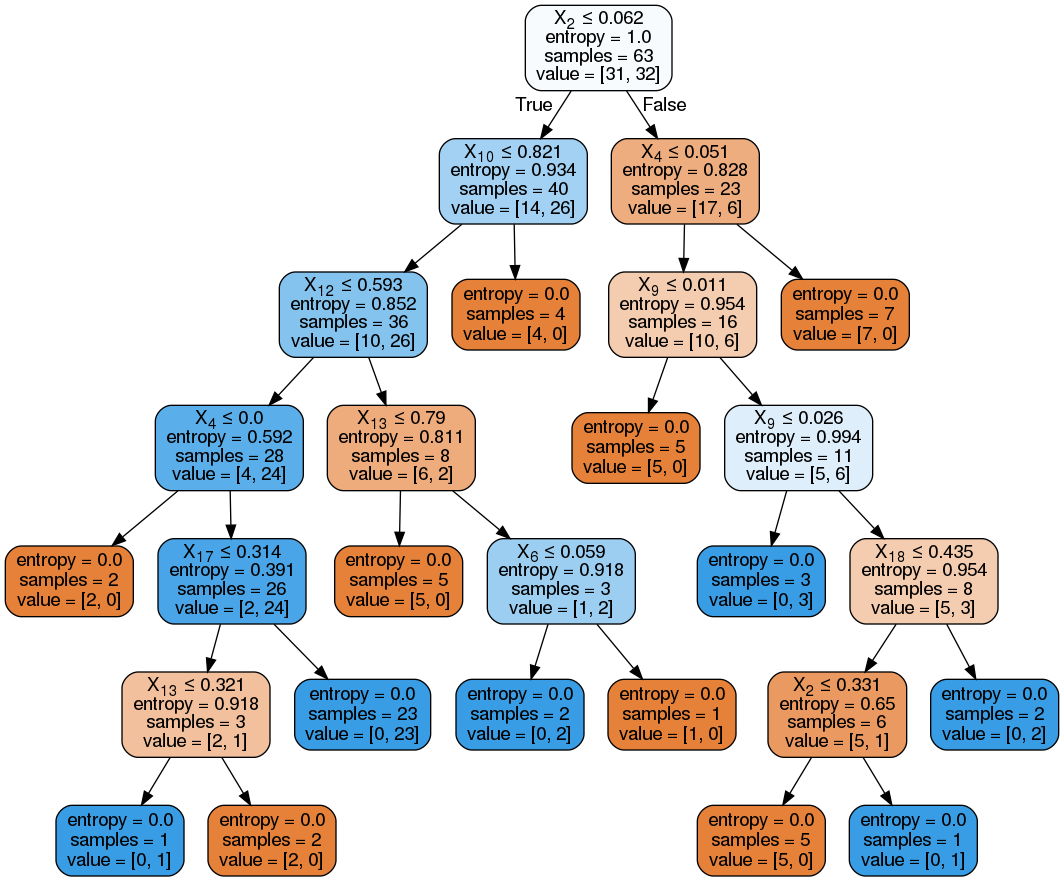

accuracy score 0.4597014925373134
confusion matrix
[[81 89]
 [92 73]]
Disp_index_00_16_count regression 50/50 split
size of training set (679,) size of testing set 335 original (1014,)
description
count     335.000000
mean       -1.601298
std       173.848925
min      -457.035826
25%       -94.682974
50%        -2.338562
75%        75.699647
max      1646.369090
Name: diff, dtype: float64


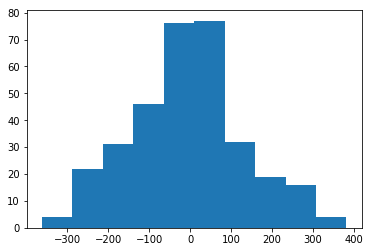

Disp_index_00_15_pctch_count regression 50/50 split
size of training set (679,) size of testing set 335 original (1014,)
description
count      335.000000
mean        48.418642
std        886.581736
min         -1.005268
25%         -0.219130
50%         -0.049328
75%          0.160325
max      16227.088345
Name: diff, dtype: float64


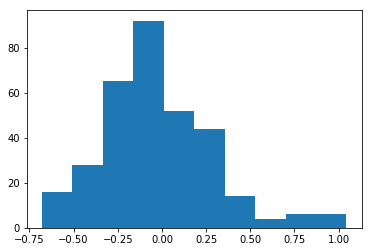

Disp_index_00_15_pctch_per regression 50/50 split
size of training set (679,) size of testing set 335 original (1014,)
description
count    335.000000
mean      -0.029828
std        0.092854
min       -0.372769
25%       -0.082770
50%       -0.028998
75%        0.022019
max        0.234939
Name: diff, dtype: float64


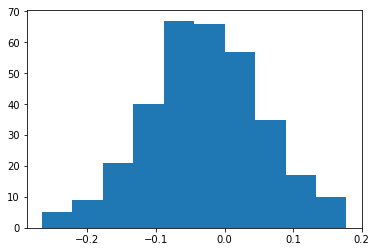

In [56]:
run_single_geography_model(df_data, df_predict, ny_00_cols, predict_ny_00_cols, "NY Stacked Decades")

# 1990s SF

previous to dropping (2137, 195) after dropping (1490, 195)
(1490, 4) (1490, 20)
gent90_00_v2 classification
size of training set (998,) size of testing set 492 original (1490,)


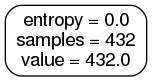

accuracy score 0.9573170731707317
confusion matrix
[[471   0]
 [ 21   0]]
Disp_index_90_00_count regression
size of training set (998,) size of testing set 492 original (1490,)
description
count     492.000000
mean        1.193533
std       199.305625
min      -978.920471
25%       -95.302055
50%        -8.695354
75%        97.786819
max      1070.678101
Name: diff, dtype: float64


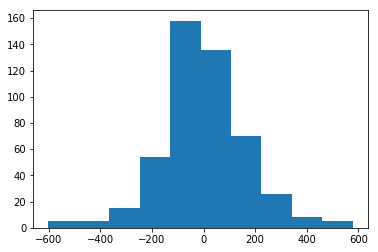

Disp_index_90_00_pctch_count regression
size of training set (998,) size of testing set 492 original (1490,)
description
count    492.000000
mean       1.045551
std       13.596475
min       -1.243487
25%       -0.214898
50%        0.013329
75%        0.259115
max      280.485074
Name: diff, dtype: float64


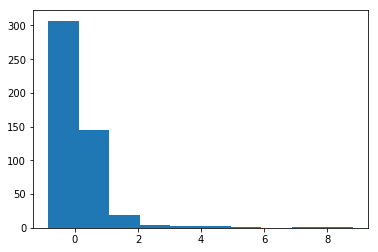

Disp_index_90_00_pctch_per regression
size of training set (998,) size of testing set 492 original (1490,)
description
count    492.000000
mean       0.053049
std        0.673138
min       -0.957258
25%       -0.148143
50%       -0.007114
75%        0.141998
max       13.095673
Name: diff, dtype: float64


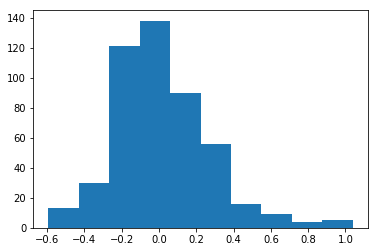

[195, 234, 313, 1341, 2030] <class 'list'> <class 'pandas.core.indexes.numeric.Int64Index'>
=====================50/50 split=============================
gent90_00_v2 classification 50/50 split
size of training set (50,) size of testing set 26 original (76,)


ValueError: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.

In [52]:
run_single_geography_model(sf_90_df, to_predict_sf, sf_90_cols, predict_sf_90_cols, "1990s SF")

# 2000s SF

previous to dropping (2137, 265) after dropping (1459, 265)
(1459, 4) (1459, 20)
gent00_15_v2 classification
size of training set (977,) size of testing set 482 original (1459,)


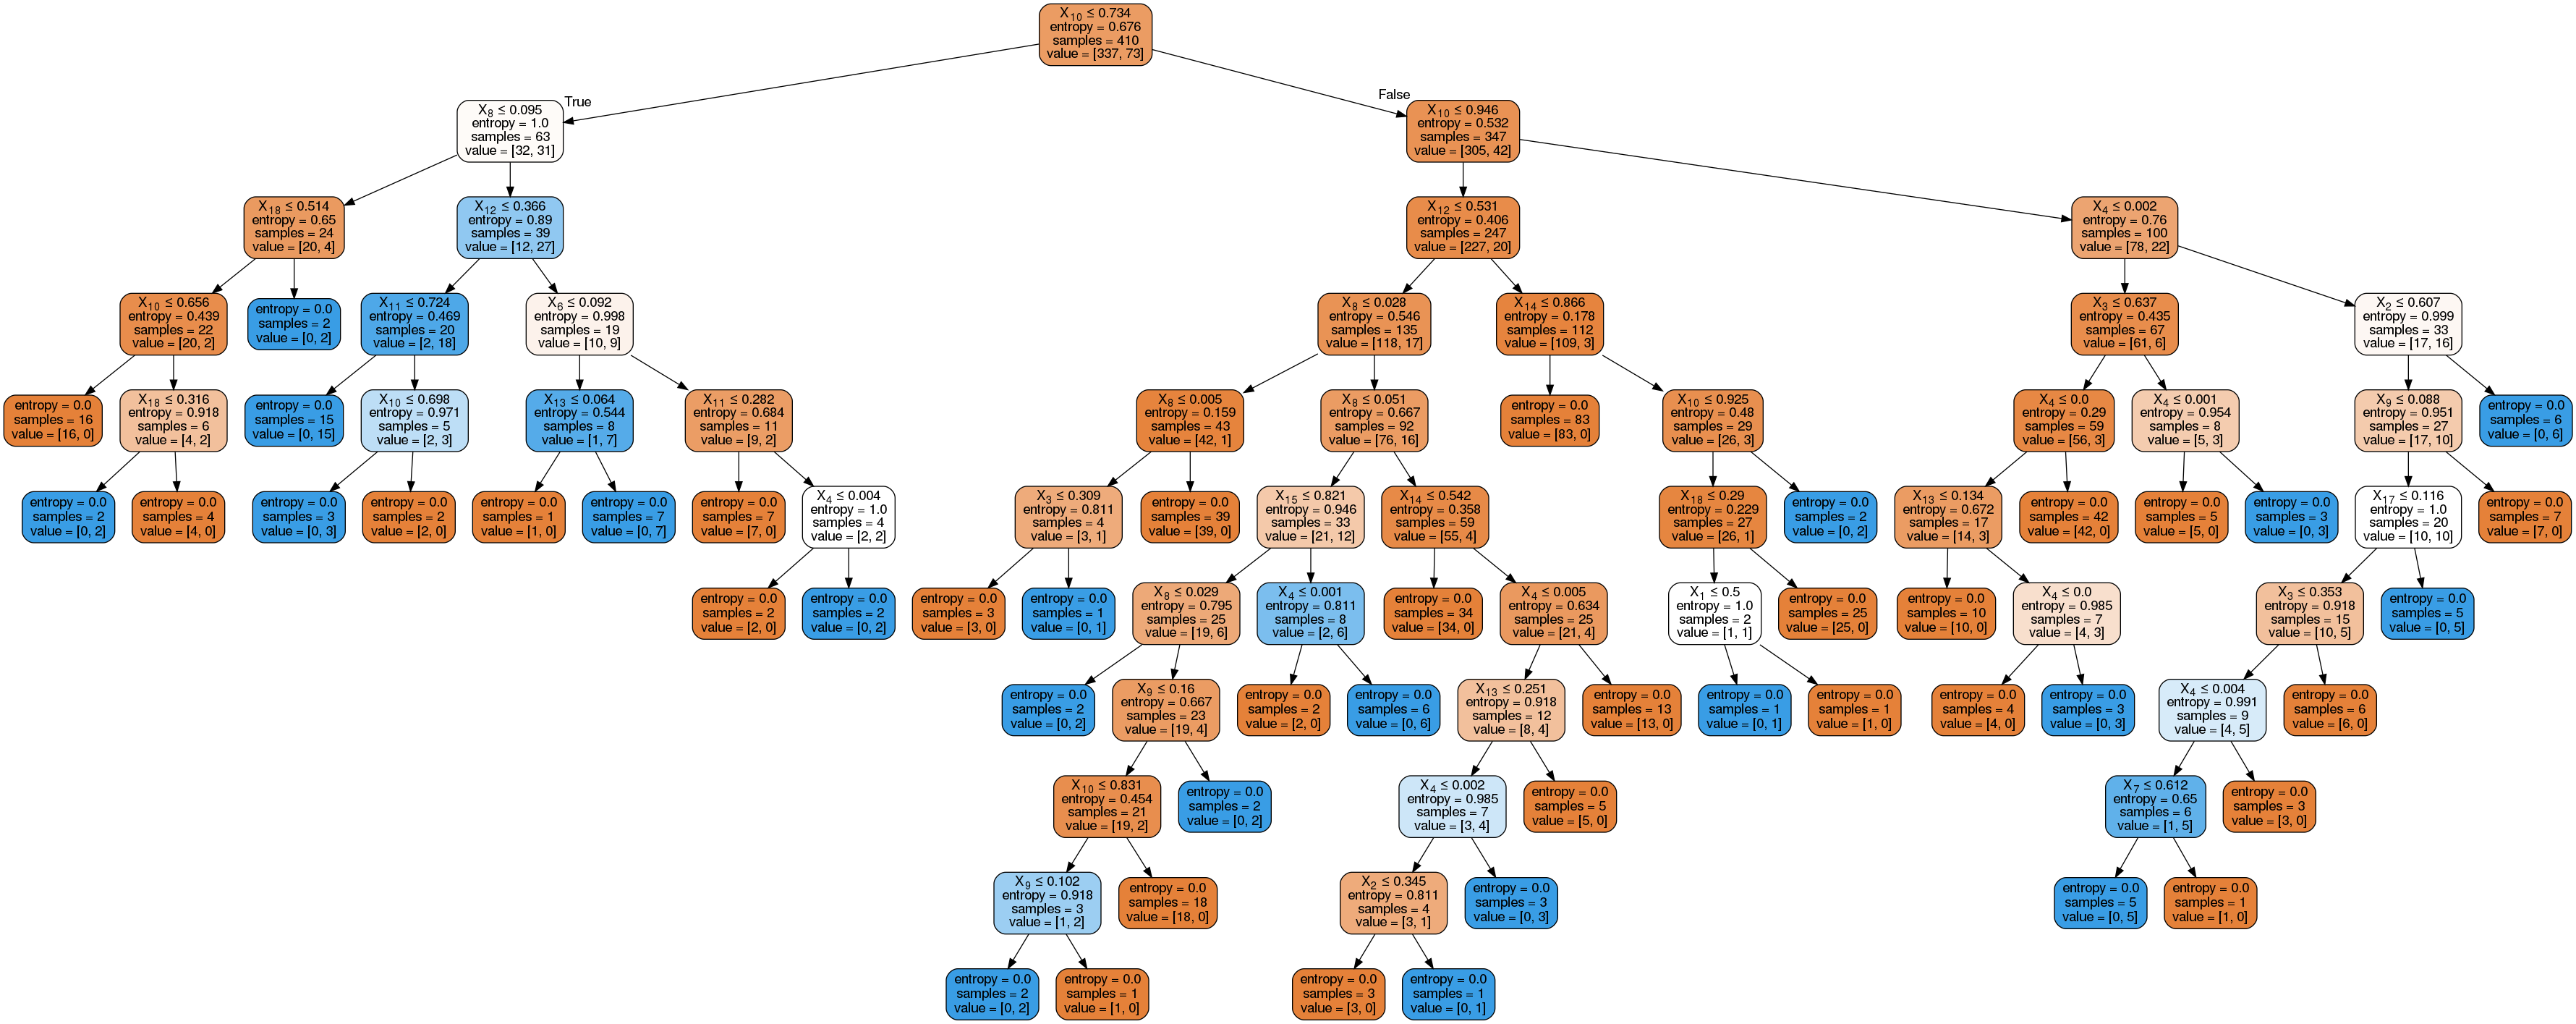

accuracy score 0.7925311203319502
confusion matrix
[[356  63]
 [ 37  26]]
Disp_index_00_15_count regression
size of training set (977,) size of testing set 482 original (1459,)
description
count    482.000000
mean      22.948955
std      184.500547
min     -426.981812
25%      -98.081886
50%       13.979233
75%      131.342087
max      660.910889
Name: diff, dtype: float64


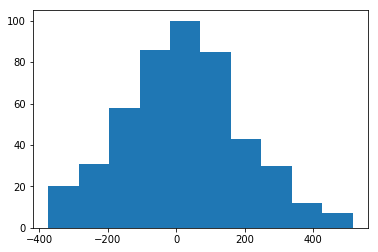

Disp_index_00_15_pctch_count regression
size of training set (977,) size of testing set 482 original (1459,)
description
count     482.000000
mean        2.794066
std        50.022531
min        -0.909987
25%        -0.209646
50%         0.019837
75%         0.283852
max      1086.198408
Name: diff, dtype: float64


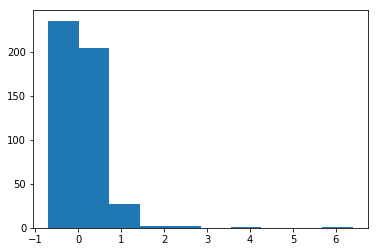

Disp_index_00_15_pctch_per regression
size of training set (977,) size of testing set 482 original (1459,)
description
count    482.000000
mean       0.032105
std        0.355076
min       -1.223091
25%       -0.183652
50%        0.018112
75%        0.187553
max        2.920023
Name: diff, dtype: float64


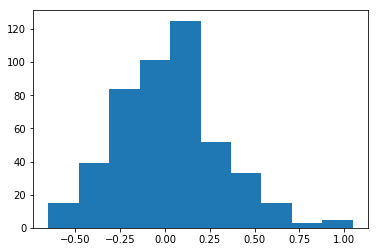

[468, 525, 1722, 1725, 213] <class 'list'> <class 'pandas.core.indexes.numeric.Int64Index'>
=====================50/50 split=============================
gent00_15_v2 classification 50/50 split
size of training set (262,) size of testing set 130 original (392,)


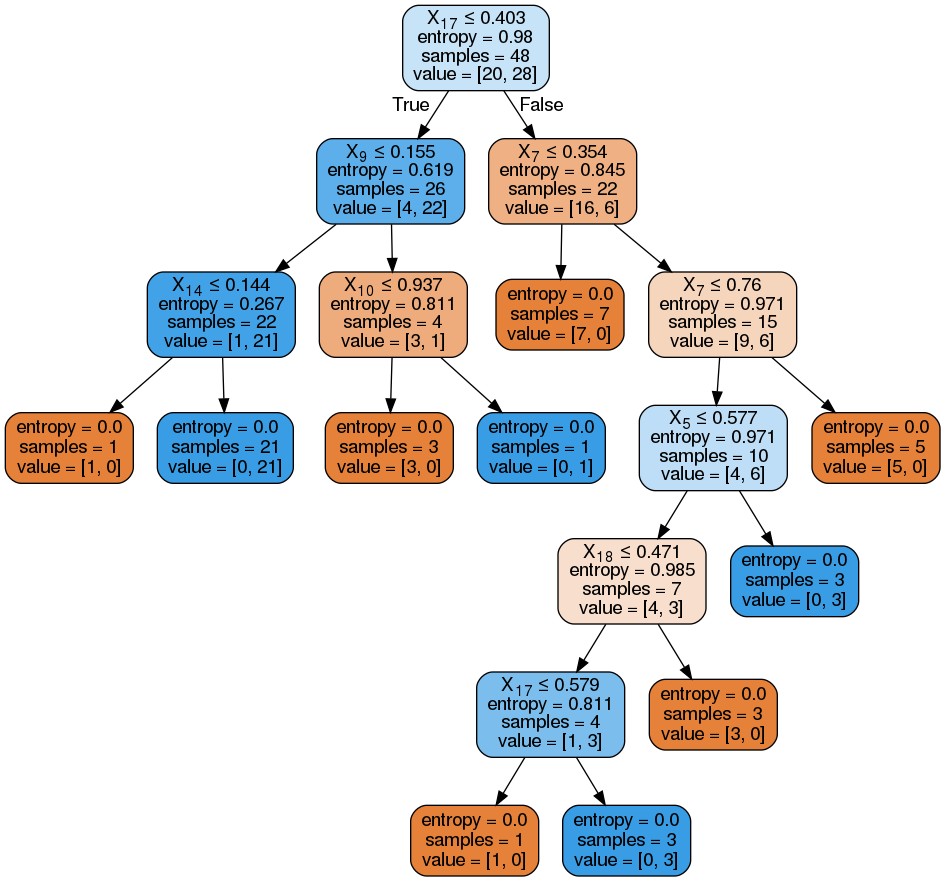

accuracy score 0.47692307692307695
confusion matrix
[[30 44]
 [24 32]]
Disp_index_00_15_count regression 50/50 split
size of training set (262,) size of testing set 130 original (392,)
description
count    130.000000
mean       8.289064
std      168.928670
min     -485.382706
25%      -93.760193
50%       15.267090
75%      112.151131
max      613.084595
Name: diff, dtype: float64


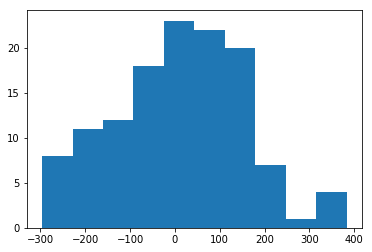

Disp_index_00_15_pctch_count regression 50/50 split
size of training set (262,) size of testing set 130 original (392,)
description
count    130.000000
mean       0.007714
std        0.438824
min       -1.025077
25%       -0.278929
50%        0.022747
75%        0.210329
max        1.482951
Name: diff, dtype: float64


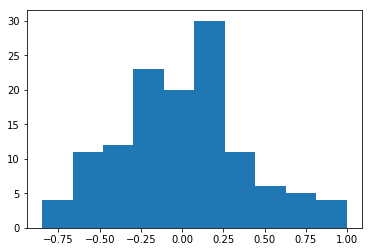

Disp_index_00_15_pctch_per regression 50/50 split
size of training set (262,) size of testing set 130 original (392,)
description
count    130.000000
mean       0.034520
std        0.337247
min       -0.896464
25%       -0.174424
50%        0.021984
75%        0.214525
max        0.948079
Name: diff, dtype: float64


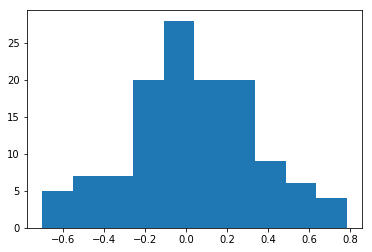

In [51]:
run_single_geography_model(sf_00_df, to_predict_sf, sf_00_cols, predict_sf_00_cols, "2000s SF")

# Stacking decades of SF Data

In [57]:
df_data, df_predict = stack_data(sf_00_df, sf_00_cols  + ["geo_fips"], sf_90_df, sf_90_cols + ["geo_fips"], to_predict_sf, predict_sf_00_cols, predict_sf_90_cols)

print(type(df_data), type(df_predict))


<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


previous to dropping (4274, 24) after dropping (3108, 24)
(3108, 4) (3108, 20)
gent00_15_v2 classification
size of training set (2082,) size of testing set 1026 original (3108,)


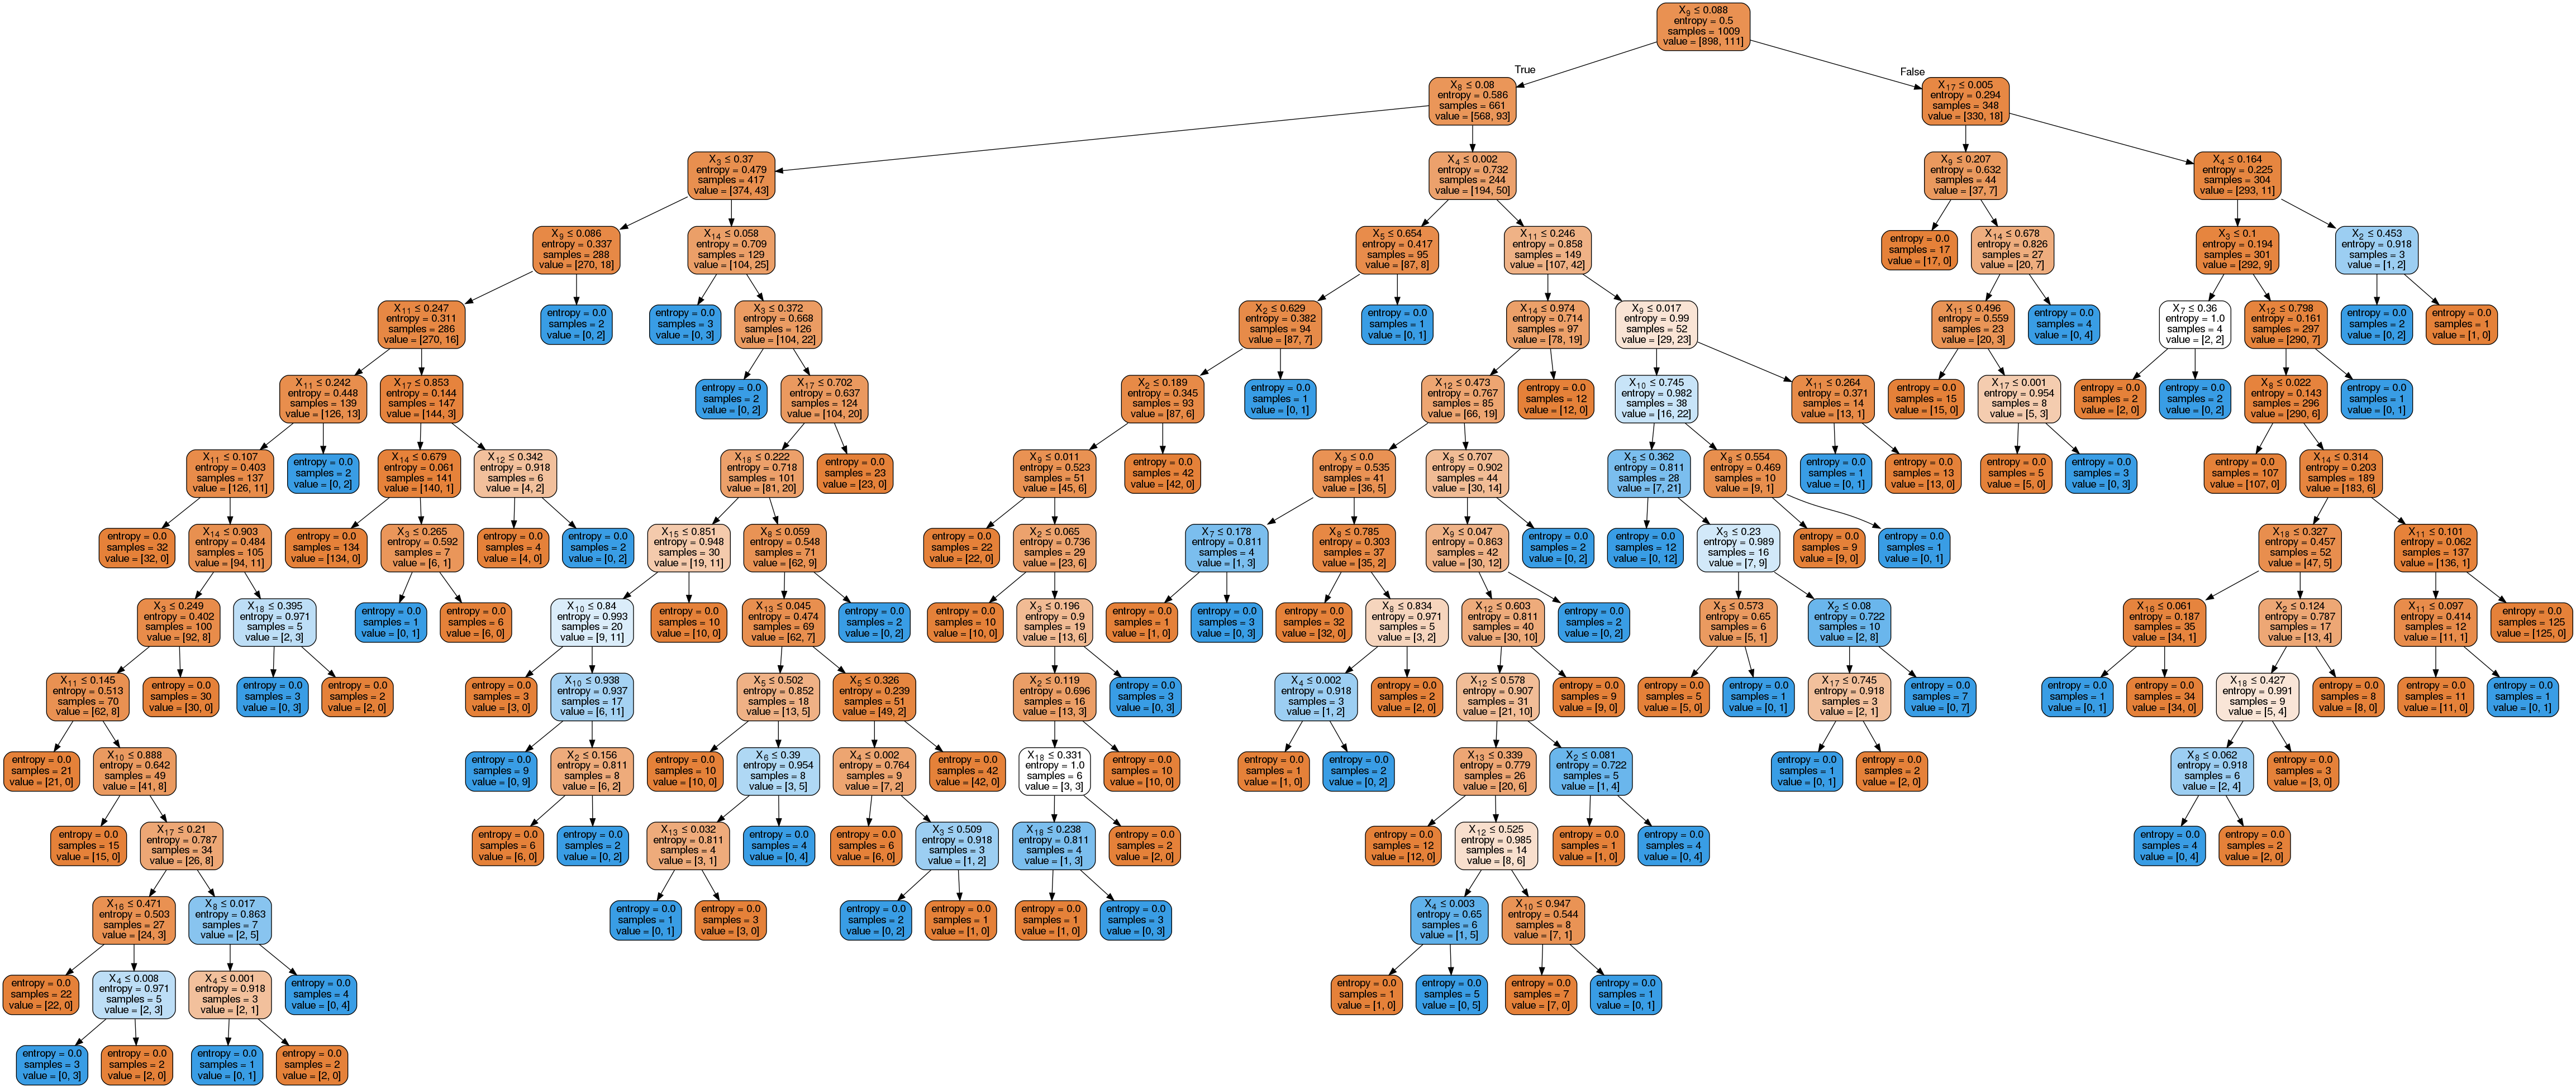

accuracy score 0.8245614035087719
confusion matrix
[[833 111]
 [ 69  13]]
Disp_index_00_15_count regression
size of training set (2082,) size of testing set 1026 original (3108,)
description
count    1026.000000
mean       16.452187
std       191.158711
min     -1004.466492
25%      -101.891823
50%        14.828735
75%       121.002712
max      1040.360229
Name: diff, dtype: float64


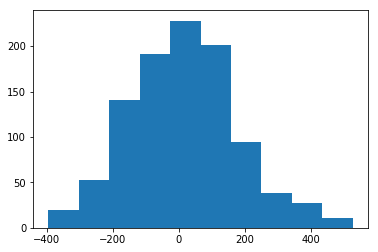

Disp_index_00_15_pctch_count regression
size of training set (2082,) size of testing set 1026 original (3108,)
description
count    1026.000000
mean        1.311059
std        25.814688
min        -1.413451
25%        -0.196741
50%         0.014016
75%         0.254101
max       789.805018
Name: diff, dtype: float64


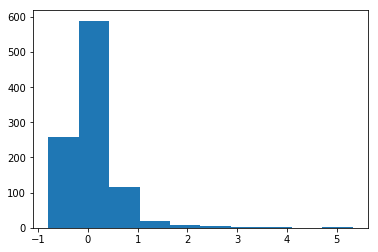

Disp_index_00_15_pctch_per regression
size of training set (2082,) size of testing set 1026 original (3108,)
description
count    1026.000000
mean        0.037659
std         0.319509
min        -1.108339
25%        -0.149849
50%         0.009038
75%         0.199378
max         3.428583
Name: diff, dtype: float64


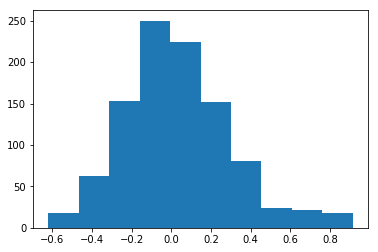

[3156, 3461, 1654, 283, 3166] <class 'list'> <class 'pandas.core.indexes.numeric.Int64Index'>
=====================50/50 split=============================
gent00_15_v2 classification 50/50 split
size of training set (333,) size of testing set 165 original (498,)


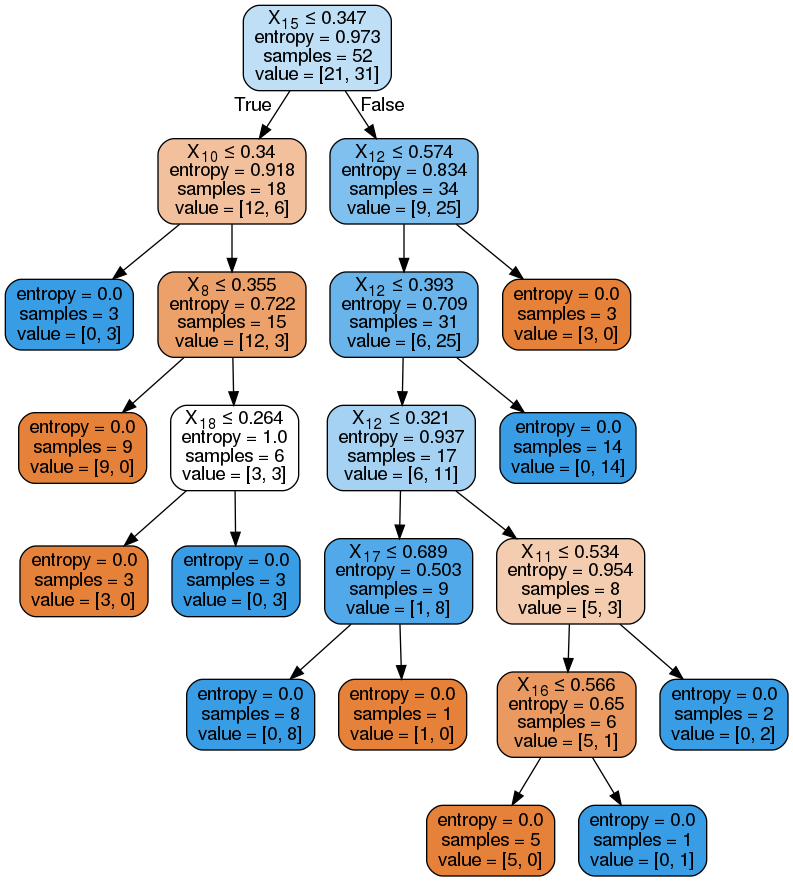

accuracy score 0.45454545454545453
confusion matrix
[[41 44]
 [46 34]]
Disp_index_00_15_count regression 50/50 split
size of training set (333,) size of testing set 165 original (498,)
description
count    165.000000
mean     -22.075381
std      184.427192
min     -554.748657
25%     -142.575928
50%      -23.580017
75%       74.089050
max      621.190979
Name: diff, dtype: float64


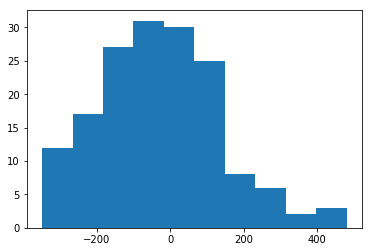

Disp_index_00_15_pctch_count regression 50/50 split
size of training set (333,) size of testing set 165 original (498,)
description
count    165.000000
mean       0.982739
std       12.551186
min       -1.384852
25%       -0.301069
50%       -0.081272
75%        0.145670
max      161.020073
Name: diff, dtype: float64


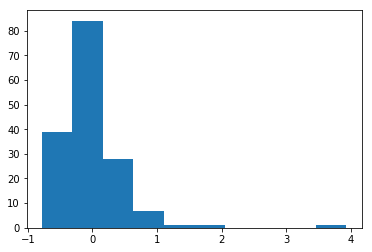

Disp_index_00_15_pctch_per regression 50/50 split
size of training set (333,) size of testing set 165 original (498,)
description
count    165.000000
mean      -0.030597
std        0.291377
min       -0.645911
25%       -0.221717
50%       -0.010613
75%        0.149915
max        1.531418
Name: diff, dtype: float64


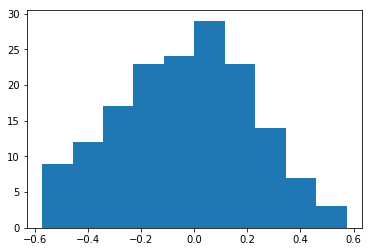

In [58]:
run_single_geography_model(df_data, df_predict, sf_00_cols, predict_sf_00_cols, "SF Stacked Decades")

# Stacking SF and NY data from 90s

In [61]:
df_data, df_predict = stack_data_diff_geographies(sf_90_df, sf_90_cols + ["geo_fips"], ny_90_df, ny_90_cols + ["geo_fips"], to_predict_sf, to_predict_ny, predict_sf_90_cols, predict_ny_90_cols)

print(type(df_data), type(df_predict), df_predict.columns)


<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> Index(['gent90_00_v2', 'Disp_index_90_00_count',
       'Disp_index_90_00_pctch_count', 'Disp_index_90_00_pctch_per'],
      dtype='object')


previous to dropping (5989, 24) after dropping (4614, 24)
(4614, 4) (4614, 20)
gent90_00_v2 classification
size of training set (3091,) size of testing set 1523 original (4614,)


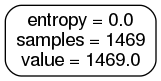

accuracy score 0.9336835193696651
confusion matrix
[[1422    0]
 [ 101    0]]
Disp_index_90_00_count regression
size of training set (3091,) size of testing set 1523 original (4614,)
description
count    1523.000000
mean       -0.748347
std       191.354934
min     -2382.002409
25%       -90.954262
50%         2.552856
75%        93.695918
max      1092.752503
Name: diff, dtype: float64


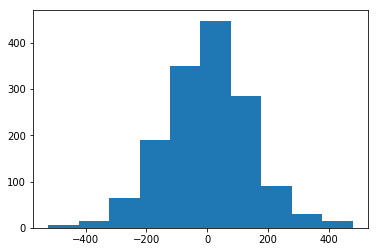

Disp_index_90_00_pctch_count regression
size of training set (3091,) size of testing set 1523 original (4614,)
description
count    1523.000000
mean        0.337251
std         7.694746
min        -1.145833
25%        -0.212319
50%        -0.015876
75%         0.203343
max       280.601731
Name: diff, dtype: float64


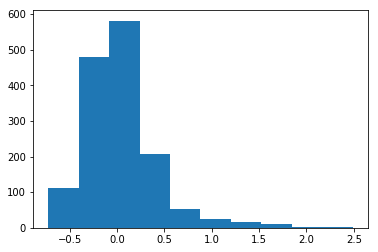

Disp_index_90_00_pctch_per regression
size of training set (3091,) size of testing set 1523 original (4614,)
description
count    1523.000000
mean        0.013969
std         0.381074
min        -1.936515
25%        -0.084423
50%        -0.001386
75%         0.080934
max        12.954749
Name: diff, dtype: float64


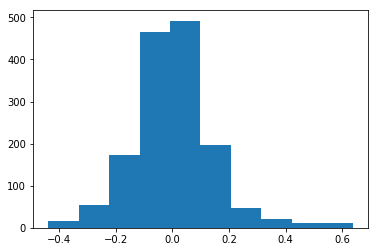

[439, 1055, 1497, 3984, 5790] <class 'list'> <class 'pandas.core.indexes.numeric.Int64Index'>
=====================50/50 split=============================
gent90_00_v2 classification 50/50 split
size of training set (408,) size of testing set 202 original (610,)


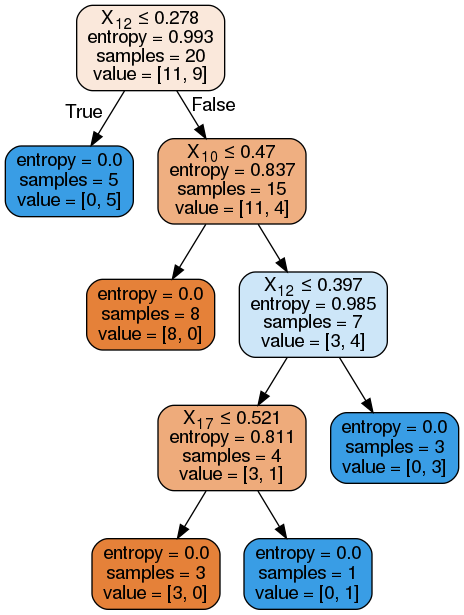

accuracy score 0.30198019801980197
confusion matrix
[[33 79]
 [62 28]]
Disp_index_90_00_count regression 50/50 split
size of training set (408,) size of testing set 202 original (610,)
description
count    202.000000
mean     -64.742573
std      158.888812
min     -568.890990
25%     -155.423019
50%      -66.180176
75%       11.231197
max      451.506775
Name: diff, dtype: float64


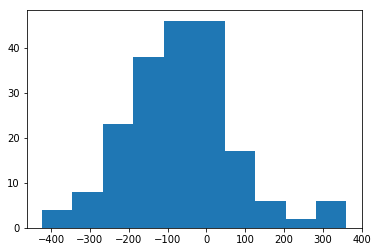

Disp_index_90_00_pctch_count regression 50/50 split
size of training set (408,) size of testing set 202 original (610,)
description
count    202.000000
mean      -0.292147
std        0.828897
min       -2.020610
25%       -0.458508
50%       -0.141475
75%        0.013386
max        5.362027
Name: diff, dtype: float64


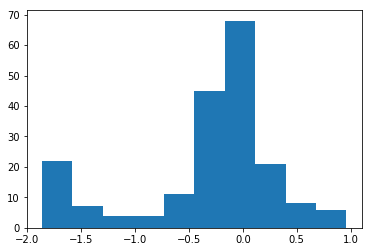

Disp_index_90_00_pctch_per regression 50/50 split
size of training set (408,) size of testing set 202 original (610,)
description
count    202.000000
mean      -0.101794
std        0.174439
min       -0.736258
25%       -0.173067
50%       -0.093801
75%       -0.012426
max        0.548644
Name: diff, dtype: float64


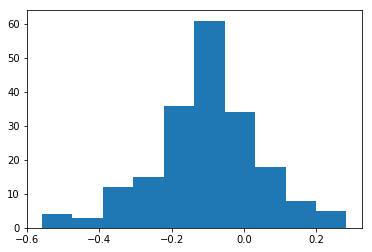

In [62]:
run_single_geography_model(df_data, df_predict, sf_90_cols, predict_sf_90_cols, "SF_NY 90s")

# Stacking SF and NY data from 00s

In [63]:
df_data, df_predict = stack_data_diff_geographies(sf_00_df, sf_00_cols + ["geo_fips"], ny_00_df, ny_00_cols + ["geo_fips"], to_predict_sf, to_predict_ny, predict_sf_00_cols, predict_ny_00_cols)

print(type(df_data), type(df_predict), df_predict.columns)


<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> Index(['gent00_15_v2', 'Disp_index_00_15_count',
       'Disp_index_00_15_pctch_count', 'Disp_index_00_15_pctch_per'],
      dtype='object')


previous to dropping (5989, 24) after dropping (4627, 24)
(4627, 4) (4627, 20)
gent00_15_v2 classification
size of training set (3100,) size of testing set 1527 original (4627,)


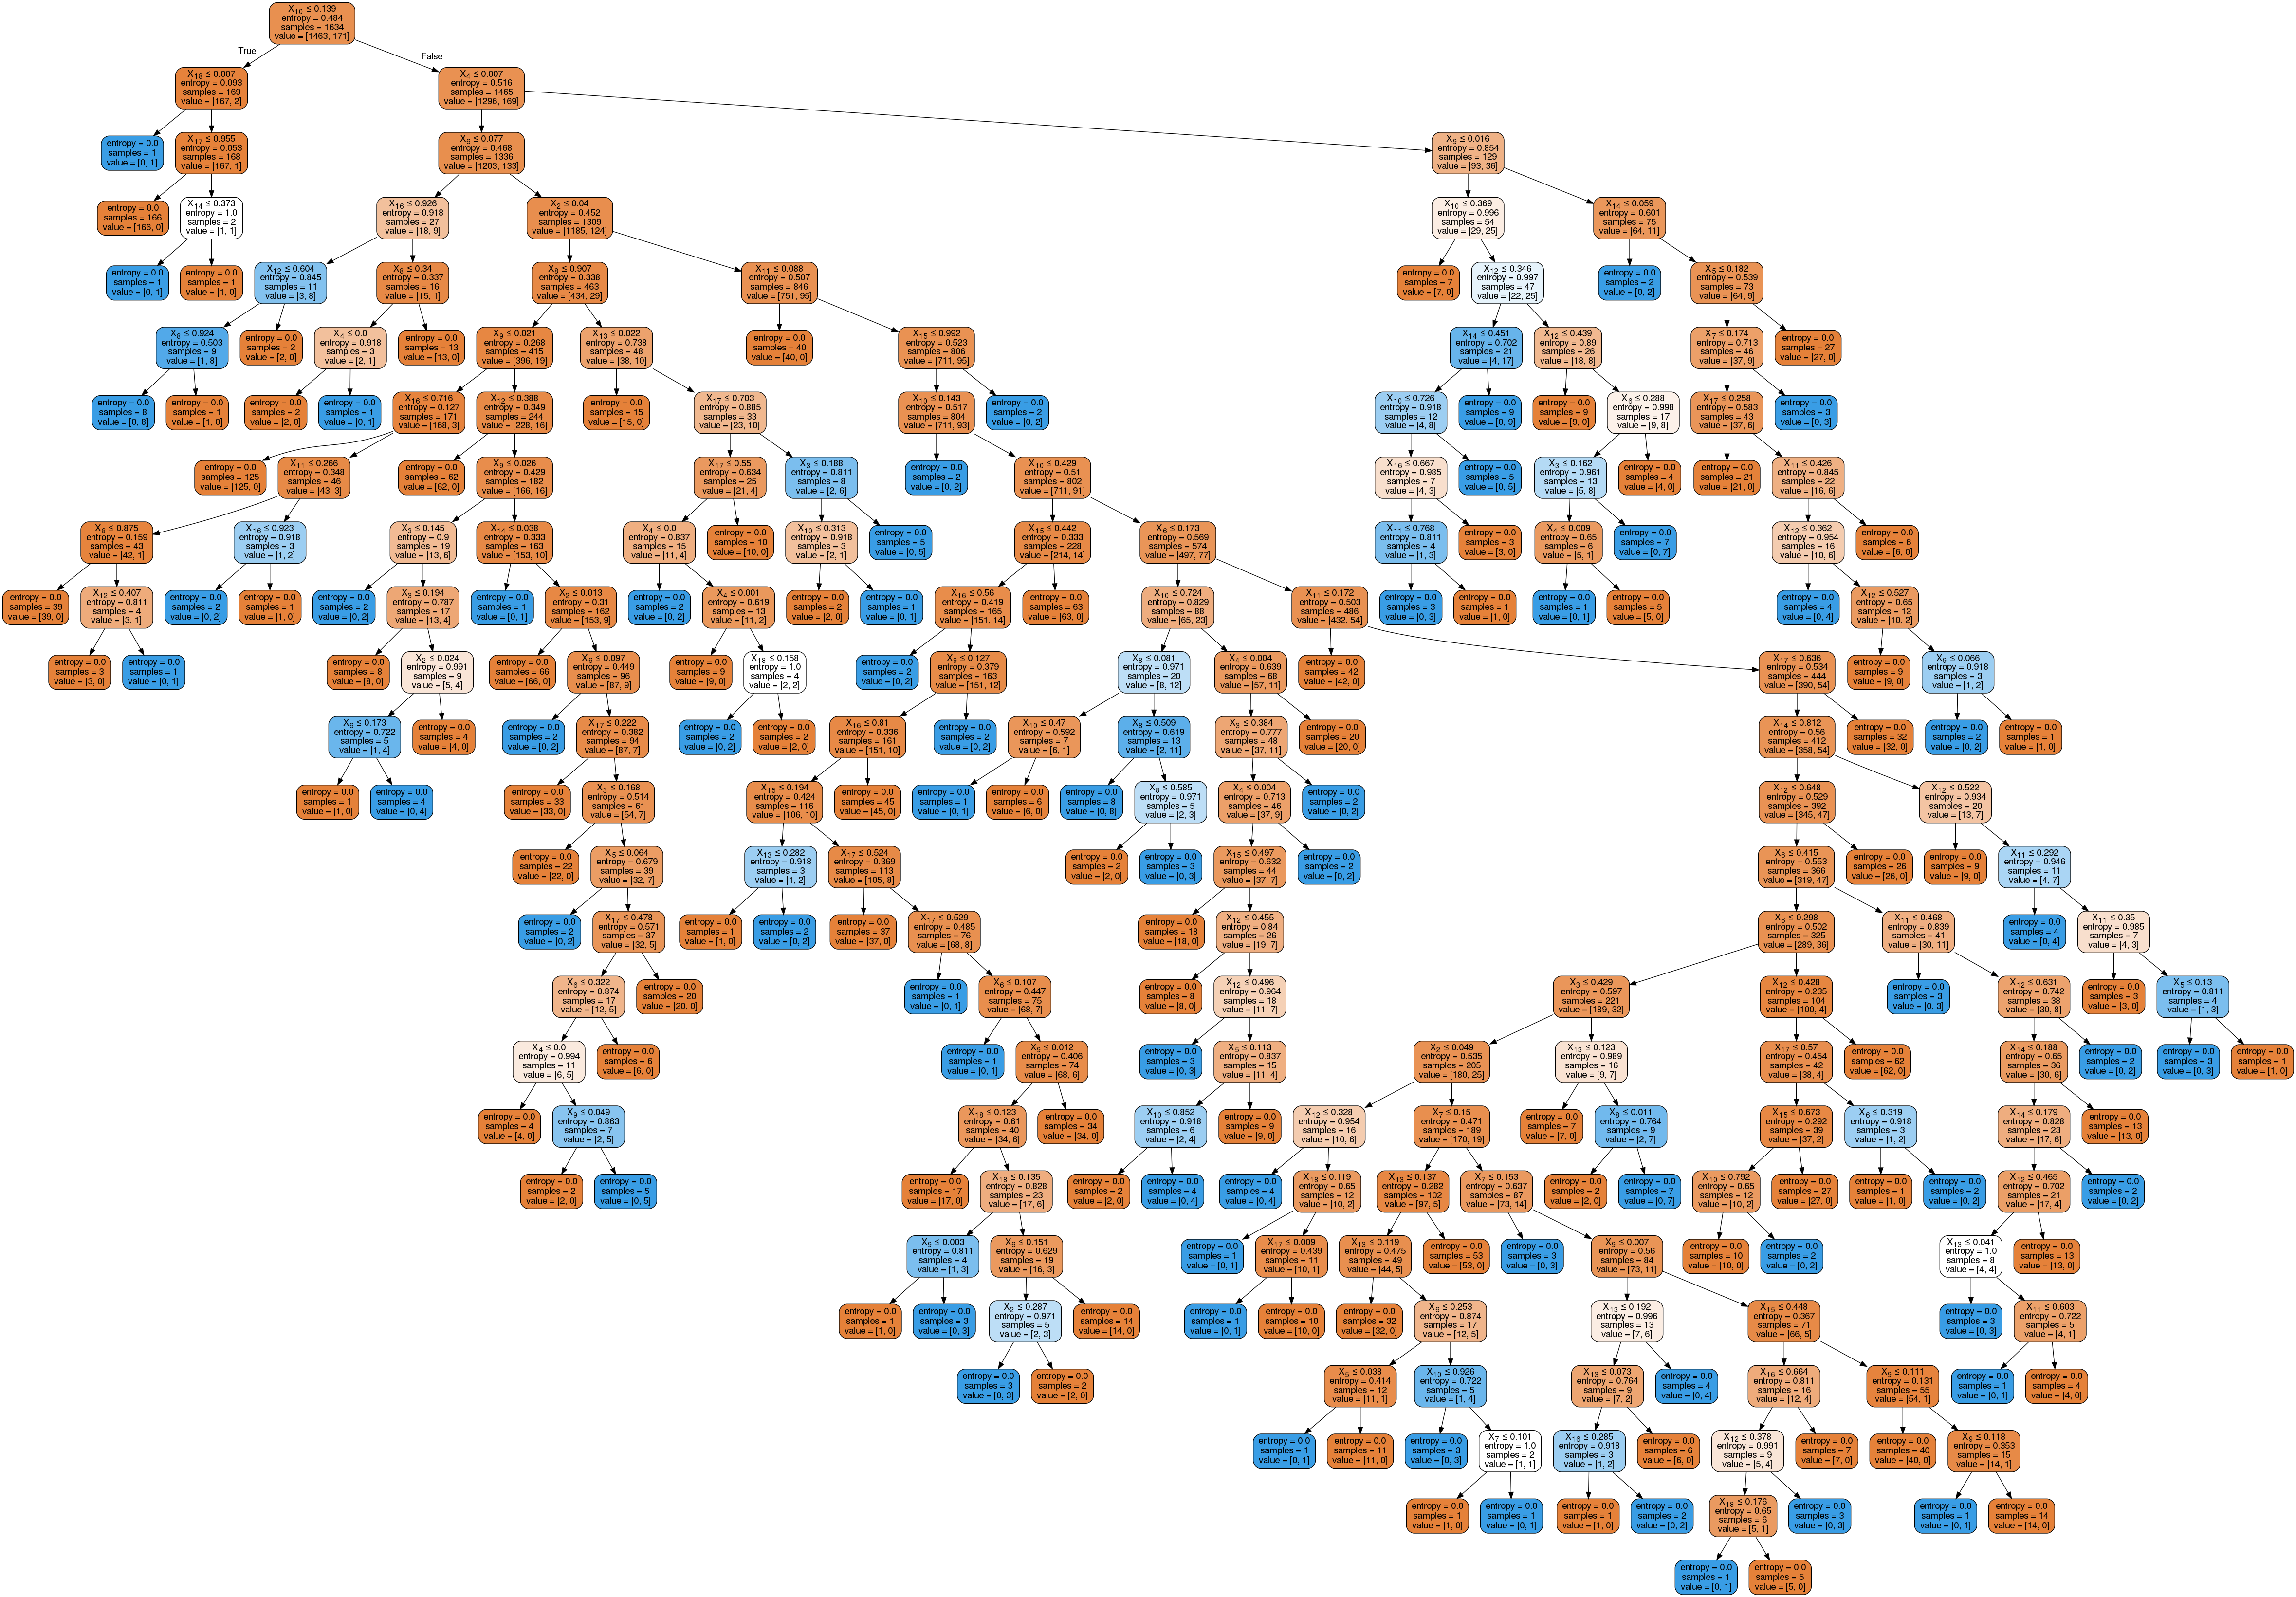

accuracy score 0.7996070726915521
confusion matrix
[[1189  169]
 [ 137   32]]
Disp_index_00_15_count regression
size of training set (3100,) size of testing set 1527 original (4627,)
description
count    1527.000000
mean       -2.527360
std       183.100951
min      -707.444883
25%      -115.581893
50%        -6.159241
75%        96.296547
max      1545.169143
Name: diff, dtype: float64


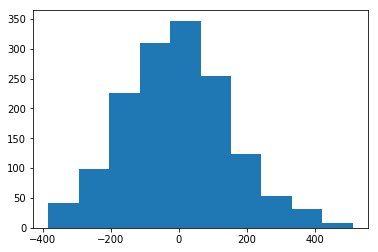

Disp_index_00_15_pctch_count regression
size of training set (3100,) size of testing set 1527 original (4627,)
description
count    1527.000000
mean        0.837035
std        21.243357
min        -1.166349
25%        -0.208703
50%        -0.001821
75%         0.202724
max       790.146566
Name: diff, dtype: float64


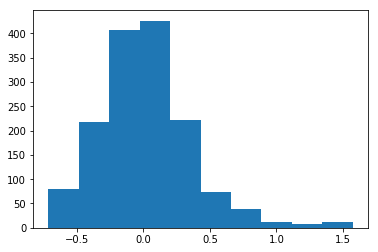

Disp_index_00_15_pctch_per regression
size of training set (3100,) size of testing set 1527 original (4627,)
description
count    1527.000000
mean        0.008594
std         0.209274
min        -1.172995
25%        -0.100576
50%        -0.004746
75%         0.089713
max         1.763551
Name: diff, dtype: float64


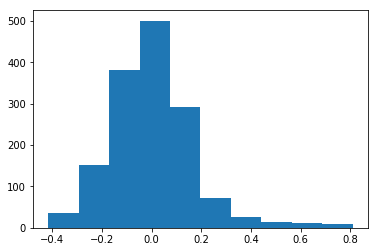

[1065, 95, 2856, 5413, 4907] <class 'list'> <class 'pandas.core.indexes.numeric.Int64Index'>
=====================50/50 split=============================
gent00_15_v2 classification 50/50 split
size of training set (604,) size of testing set 298 original (902,)


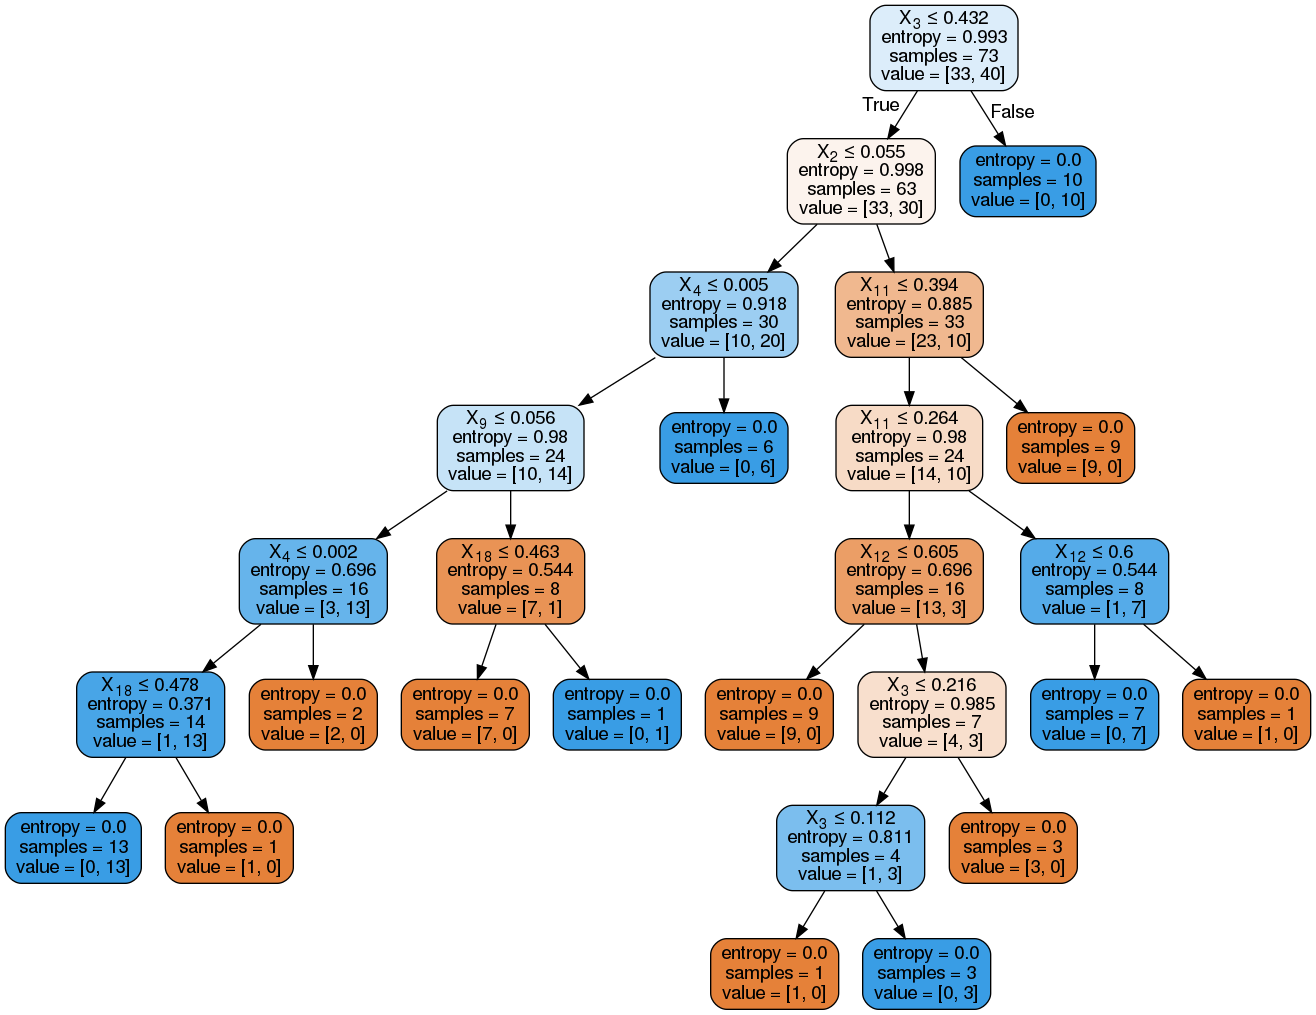

accuracy score 0.48322147651006714
confusion matrix
[[71 82]
 [72 73]]
Disp_index_00_15_count regression 50/50 split
size of training set (604,) size of testing set 298 original (902,)
description
count     298.000000
mean      -42.581016
std       161.549055
min      -405.744019
25%      -140.283678
50%       -40.943710
75%        39.569324
max      1058.734293
Name: diff, dtype: float64


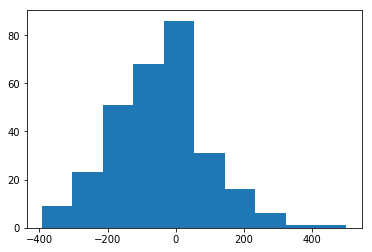

Disp_index_00_15_pctch_count regression 50/50 split
size of training set (604,) size of testing set 298 original (902,)
description
count    298.000000
mean      -0.066779
std        0.418794
min       -0.905335
25%       -0.301592
50%       -0.091827
75%        0.121625
max        4.571043
Name: diff, dtype: float64


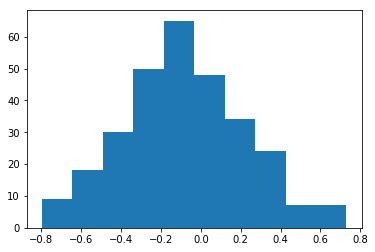

Disp_index_00_15_pctch_per regression 50/50 split
size of training set (604,) size of testing set 298 original (902,)
description
count    298.000000
mean      -0.038841
std        0.196381
min       -0.963412
25%       -0.133867
50%       -0.038244
75%        0.063390
max        0.845969
Name: diff, dtype: float64


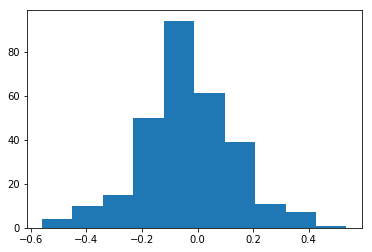

In [64]:
run_single_geography_model(df_data, df_predict, sf_00_cols, predict_sf_00_cols, "SF_NY 00s")

# Mixing up all of the Data

In [65]:
df_data_90, df_predict_90 = stack_data_diff_geographies(sf_90_df, sf_90_cols + ["geo_fips"], ny_90_df, ny_90_cols + ["geo_fips"], to_predict_sf, to_predict_ny, predict_sf_90_cols, predict_ny_90_cols)
df_data_00, df_predict_00 = stack_data_diff_geographies(sf_00_df, sf_00_cols + ["geo_fips"], ny_00_df, ny_00_cols + ["geo_fips"], to_predict_sf, to_predict_ny, predict_sf_00_cols, predict_ny_00_cols)
df_data, df_predict = stack_data_diff_geographies(df_data_90, sf_90_cols + ["geo_fips"], df_data_00, sf_00_cols + ["geo_fips"], df_predict_90, df_predict_00, predict_sf_90_cols, predict_sf_00_cols)


previous to dropping (11978, 24) after dropping (9241, 24)
(9241, 4) (9241, 20)
gent90_00_v2 classification
size of training set (6191,) size of testing set 3050 original (9241,)


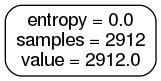

accuracy score 0.9160655737704918
confusion matrix
[[2794    0]
 [ 256    0]]
Disp_index_90_00_count regression
size of training set (6191,) size of testing set 3050 original (9241,)
description
count    3050.000000
mean       -5.092640
std       197.644962
min     -2290.265044
25%      -105.606980
50%        -8.808746
75%        89.001882
max      1529.531555
Name: diff, dtype: float64


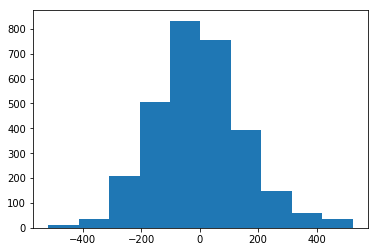

Disp_index_90_00_pctch_count regression
size of training set (6191,) size of testing set 3050 original (9241,)
description
count    3050.000000
mean        0.548572
std        20.366352
min        -1.209106
25%        -0.227236
50%        -0.017772
75%         0.190735
max      1086.624312
Name: diff, dtype: float64


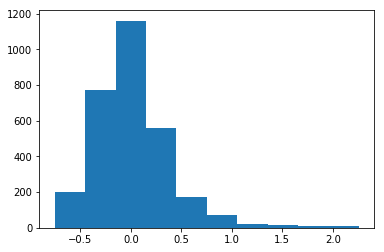

Disp_index_90_00_pctch_per regression
size of training set (6191,) size of testing set 3050 original (9241,)
description
count    3050.000000
mean        0.005064
std         0.202724
min        -1.979428
25%        -0.093198
50%        -0.004291
75%         0.082627
max         3.038814
Name: diff, dtype: float64


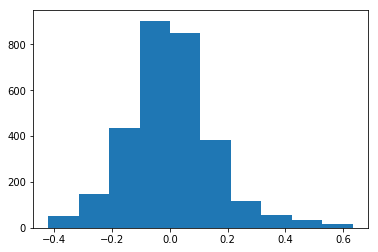

[1536, 2834, 7525, 3814, 7575] <class 'list'> <class 'pandas.core.indexes.numeric.Int64Index'>
=====================50/50 split=============================
gent90_00_v2 classification 50/50 split
size of training set (1013,) size of testing set 499 original (1512,)


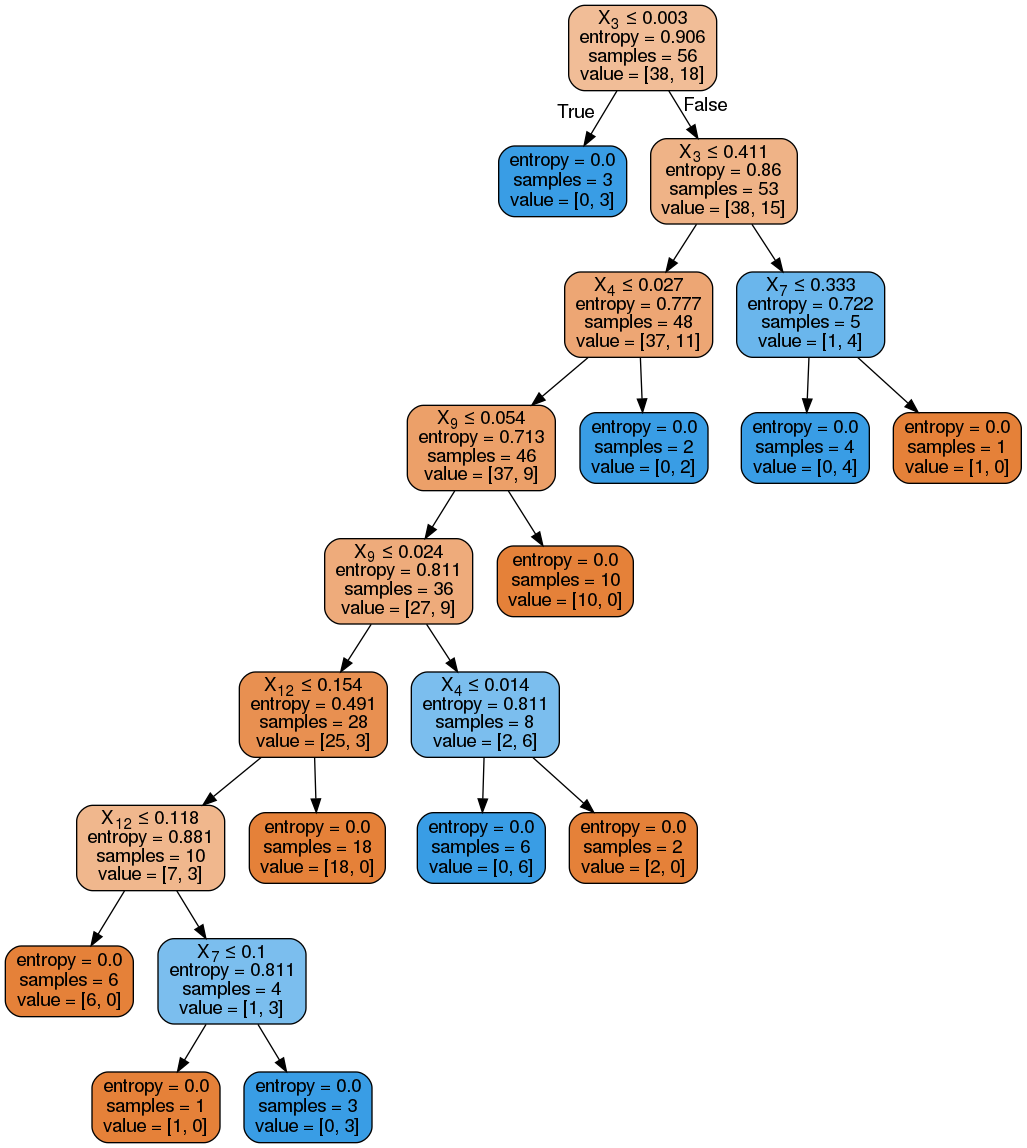

accuracy score 0.5470941883767535
confusion matrix
[[152  91]
 [135 121]]
Disp_index_90_00_count regression 50/50 split
size of training set (1013,) size of testing set 499 original (1512,)
description
count    499.000000
mean     -25.406316
std      168.513827
min     -534.037077
25%     -138.740005
50%      -37.749939
75%       68.705467
max      763.874512
Name: diff, dtype: float64


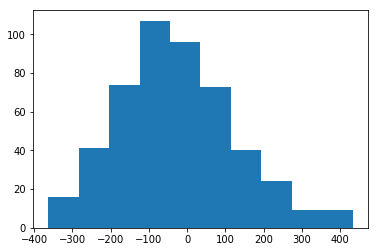

Disp_index_90_00_pctch_count regression 50/50 split
size of training set (1013,) size of testing set 499 original (1512,)
description
count      499.000000
mean        32.517757
std        726.435230
min         -0.890740
25%         -0.266858
50%         -0.068189
75%          0.130418
max      16227.325230
Name: diff, dtype: float64


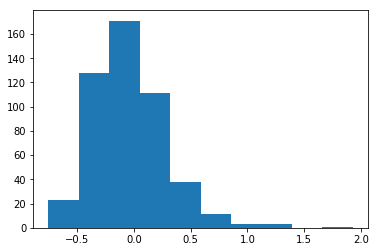

Disp_index_90_00_pctch_per regression 50/50 split
size of training set (1013,) size of testing set 499 original (1512,)
description
count    499.000000
mean      -0.006529
std        0.184026
min       -0.713080
25%       -0.123767
50%       -0.003514
75%        0.098598
max        0.973990
Name: diff, dtype: float64


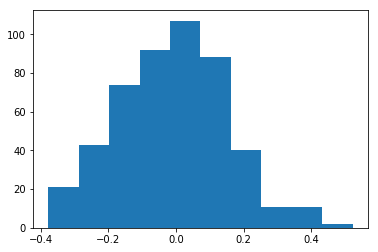

In [66]:
run_single_geography_model(df_data, df_predict, sf_90_cols, predict_sf_90_cols, "SF_NY Mixed Decades")